In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import os

In [0]:
# Extract frames of a video

import cv2
import numpy as np

def extract_frames(path1, path2):
  cap = cv2.VideoCapture(path1)

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
    print("Error opening video stream or file")

    # Read until video is completed
  i = 0
  while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
  
      # Write Frames
      cv2.imwrite(path2 + str(i) + ".png", frame)
      i += 1

      # Press Q on keyboard to  exit
      if cv2.waitKey(25) & 0xFF == ord('q'):
        break
  
    # Break the loop
    else: 
      break

  # When everything done, release the video capture object
  cap.release()
  
  # Closes all the frames
  cv2.destroyAllWindows()

extract_frames('drive/My Drive/Guitar.avi', "drive/My Drive/SinGAN/SinGAN-master/Input/Images/Guitar")

In [0]:
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [0]:
# Restart runtime prior to this, to let installation take effect

# Some basic setup
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import os
import sys

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Get Drive 
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
# Define a Mask-R-CNN model in Detectron2
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # Detection Threshold 
cfg.MODEL.ROI_HEADS.NMS = 0.8 # Non Maximum Suppression Threshold 
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
model = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:11, 15.4MB/s]                           


In [0]:
# Plot bounding box and automatically crop all instances of a given class in a given region 

from detectron2.utils.visualizer import Visualizer

def plot_bb(path):
  im = cv2.imread(path)
  outputs = model(im)
  # Example - Plot a bounding box
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1])

def crop_class(model, path, clas=0):
  # Load image
  im = cv2.imread(path)
  outputs = model(im)

  # Plot bounding box
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1])

  # Get detections, init mask
  with torch.no_grad():
      detections = model(im)["instances"]

  binary_mask = np.zeros((im.shape[0],im.shape[1],im.shape[2]))

  # Bounding boxes of humans
  if len(detections.scores)>0:
    index_class = np.where(detections.pred_classes.cpu().numpy()==clas)[0] # 0 is the default class number of human
    if len(index_class)>0:
      print(len(index_class), class "detected")
      crop=0
      for i in range(len(index_class)):
        # Crop the human out
        [x1,y1,x2,y2] = detections.pred_boxes[index_class][i].tensor[0].cpu().numpy()
        if y2>150 or (y2<70 and y2>50): # for frames, interactive with human ideally - precise the region in which we want to crop objects
          crop+=1
          [x1,y1,x2,y2] = [int(x1),int(y1),int(x2)+1,int(y2)+1] # not much margin
          im[y1:y2, x1:x2, :] = 255
          binary_mask[y1:y2, x1:x2, :] = 1
      print(crop, clas, "cropped")
      # Save image and binary mask
      cv2.imwrite(path.split(".")[0]+"_autod."+path.split("/")[-1].split(".")[1], im)
      plt.imsave(path[:-(len(path.split("/")[-2])+len(path.split("/")[-1]))-1]+"Inpainting/"+path.split("/")[-1].split(".")[0]+"_autod_mask."+path.split("/")[-1].split(".")[1], binary_mask, dpi=1000)
  return(im, binary_mask, index_class, detections)

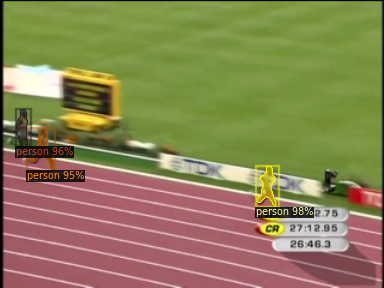

In [0]:
plot_bb("drive/My Drive/SinGAN/SinGAN-master/Input/Images/Bekeleframe0.png" )

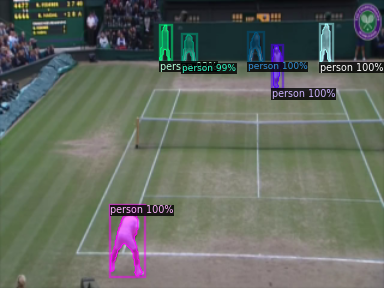

In [0]:
plot_bb("drive/My Drive/Fed.png")

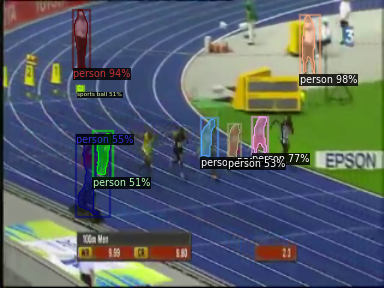

In [0]:
plot_bb("drive/My Drive/Boltframe1.png")

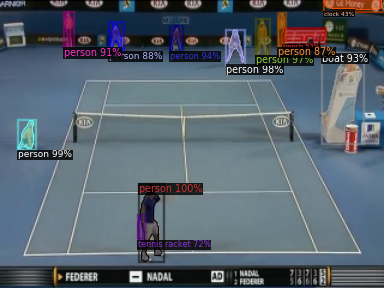

In [0]:
plot_bb("drive/My Drive/Nadalframe0.png")

In [0]:
# Crop all instances of a given class in a given region

from detectron2.utils.visualizer import Visualizer
def crop_humans(model, path):
  # Load image
  im = cv2.imread(path)
  outputs = model(im)

  # Example - Plot a bounding box
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1])

  # Get detections, init mask
  with torch.no_grad():
      detections = model(im)["instances"]

  binary_mask = np.zeros((im.shape[0],im.shape[1],im.shape[2]))

  # Bounding boxes of humans
  if len(detections.scores)>0:
    index_humans = np.where(detections.pred_classes.cpu().numpy()==0)[0] # 0 is the default class number of human
    if len(index_humans)>0:
      print(len(index_humans), "human detected")
      crop=0
      for i in range(len(index_humans)):
        # Crop the human out
        [x1,y1,x2,y2] = detections.pred_boxes[index_humans][i].tensor[0].cpu().numpy()
        if x1>20 and x2<270 and y2>50: # for frames, interactive with human ideally, to be tuned else!
          crop+=1
          [x1,y1,x2,y2] = [int(x1),int(y1),int(x2)+1,int(y2)+1]
          im[y1:y2, x1:x2, :] = 255
          binary_mask[y1:y2, x1:x2, :] = 1
      print(crop, "humans cropped")
      # Save image and binary mask
      cv2.imwrite(path.split(".")[0]+"_autod."+path.split("/")[-1].split(".")[1], im)
      plt.imsave(path[:-(len(path.split("/")[-2])+len(path.split("/")[-1]))-1]+"Inpainting/"+path.split("/")[-1].split(".")[0]+"_autod_mask."+path.split("/")[-1].split(".")[1], binary_mask, dpi=1000)
  return(im, binary_mask, index_humans, detections)

for i in range(140):
  im, binary_mask, index_humans, detections = crop_humans(model, path = "drive/My Drive/SinGAN/SinGAN-master/Input/Images/frame"+str(i)+".png")

In [0]:
# Write Video
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# Define the fps to be equal to 10. Also frame size is passed.
import cv2
w = 384
h = 288
out = cv2.VideoWriter('drive/My Drive/BoxBolt.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 24, (w,h))

for i in range(185): # nb of frames
  im = cv2.imread("drive/My Drive/SinGAN/SinGAN-master/Input/Images/Bolt/Boltframe%d.png" %i)
  outputs = model(im)
  # Example - Plot a bounding box
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  img = v.get_image()[:, :, ::-1]
  cv2.imwrite('drive/My Drive/SinGAN/SinGAN-master/Input/Images/Bolt/Boltframe%dbox.png'%i, img)

for i in range(185): # nb of frames
  img = cv2.imread('drive/My Drive/SinGAN/SinGAN-master/Input/Images/Bolt/Boltframe%dbox.png'%i)
  out.write(img)

cv2.destroyAllWindows()
out.release()